In [ ]:
!pip install -q datasets transformers sentence_transformers faiss-gpu

In [ ]:
from google.colab import userdata
hf_token = userdata.get('huggingface')

In [ ]:
from datasets import load_dataset

dataset = load_dataset('garage-bAInd/Open-Platypus')

In [ ]:
dataset["train"].to_pandas()

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-hf')

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
combined_token_counts

In [ ]:
def plot_distribution(token_counts, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 6))
  plt.hist(token_counts, bins=50, color="#3498db", edgecolor="black")
  plt.title(title, fontsize=16)
  plt.xlabel("Number of tokens", fontsize=14)
  plt.ylabel("Number of examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

plot_distribution(instruction_token_counts, "Distribution of token counts for instruction")
plot_distribution(output_token_counts, "Distribution of token counts for output")
plot_distribution(combined_token_counts, "Distribution of token counts for combined")

31


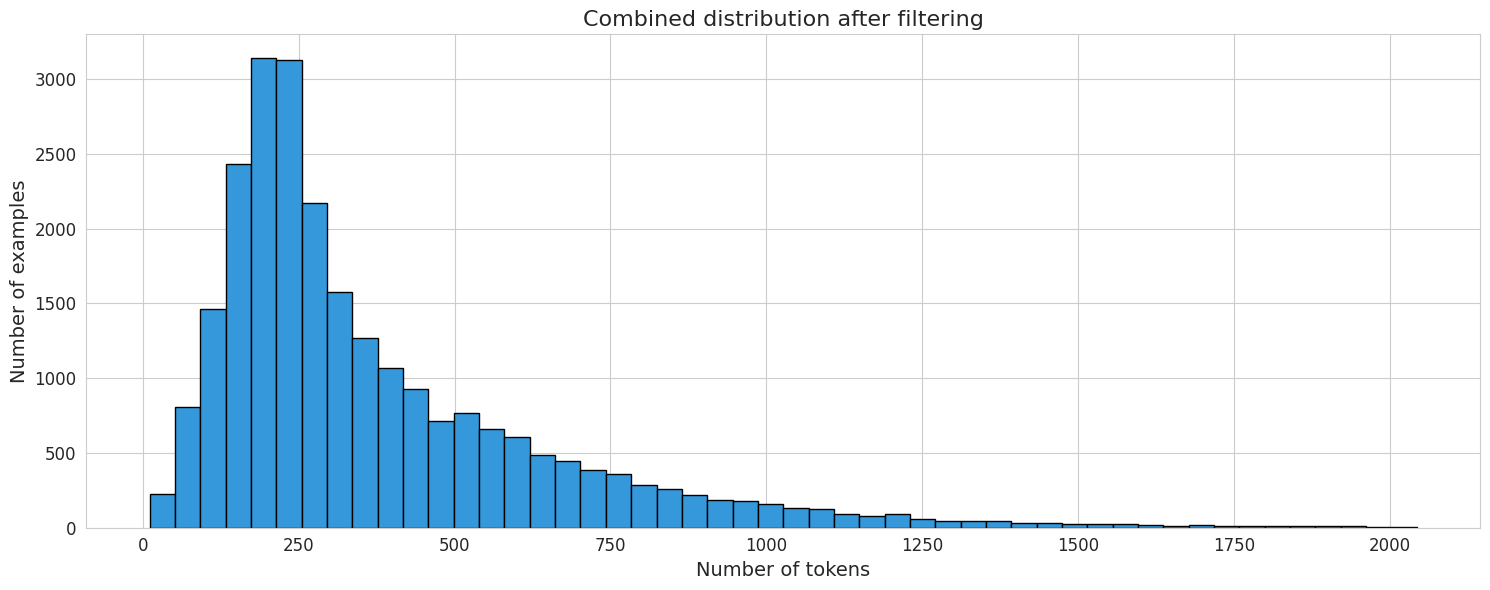

In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(len(dataset["train"]) - len(valid_indices))

dataset["train"] = dataset["train"].select(valid_indices)

token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "Combined distribution after filtering")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
  sentence_model = SentenceTransformer(model)
  outputs = [example["output"] for example in dataset["train"]]

  print("Converting text to embeddings..")
  embeddings = sentence_model.encode(outputs, show_progress_bar=True)
  dimension = embeddings.shape[1]
  index = faiss.IndexFlatIP(dimension)
  normalised_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  index.add(normalised_embeddings)

  print("Filtering out near duplicates..")
  D, I = index.search(normalised_embeddings, k=2)
  to_keep = []
  for i in tqdm(range(len(embeddings)), desc="Filtering"):
    if D[i, 1] < threshold:
      to_keep.append(i)
  dataset = dataset["train"].select(to_keep)
  return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

Converting text to embeddings..


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near duplicates..


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [ ]:
print(len(dataset["train"]))
print(len(deduped_dataset["train"]))
print(len(deduped_dataset["train"]) - len(dataset["train"]))

24895
16489
-8406


In [ ]:
def get_top_k_rows(dataset, token_counts, k):
  sorted_indices = sorted(range(len(token_counts)), key= lambda i: token_counts[i], reverse=True)
  top_k_indices = sorted_indices[:k]

  top_k_data = {
      "instruction": [dataset["train"][i]["instruction"] for i in top_k_indices],
      "output": [dataset["train"][i]["output"] for i in top_k_indices]
  }

  return Dataset.from_dict(top_k_data)

k = 1000
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)
dataset = DatasetDict({"train": top_k_dataset})


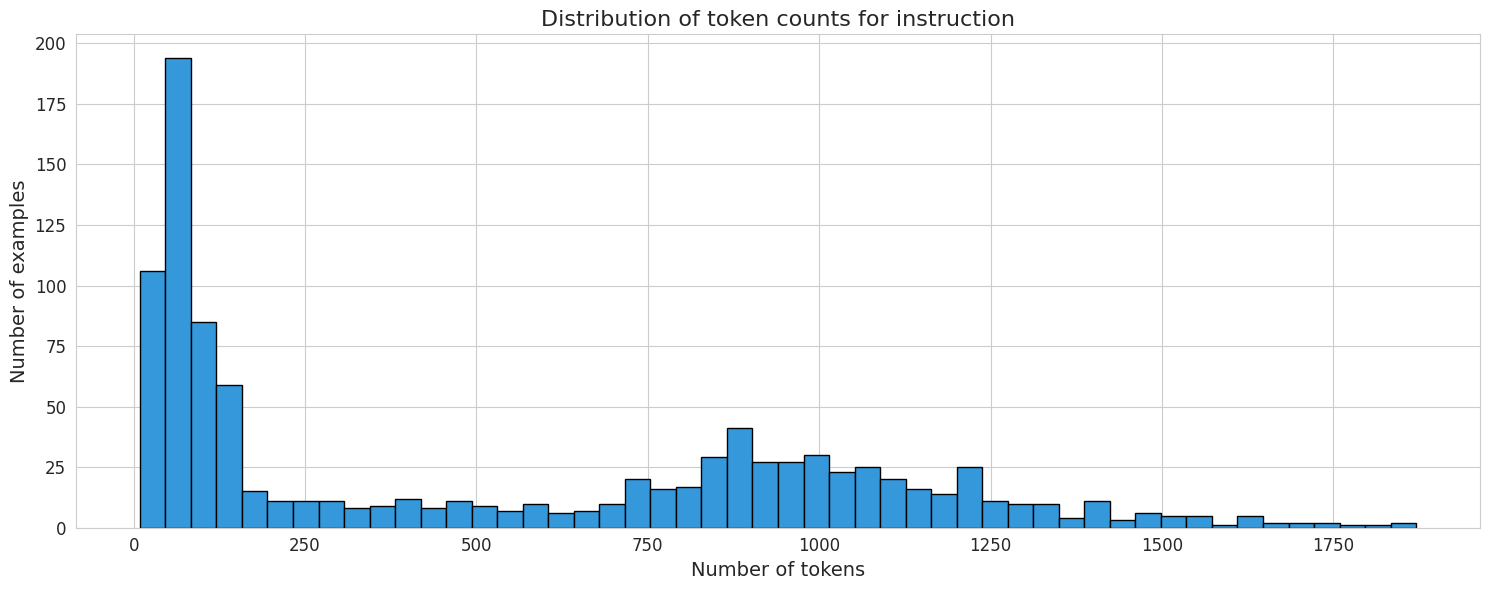

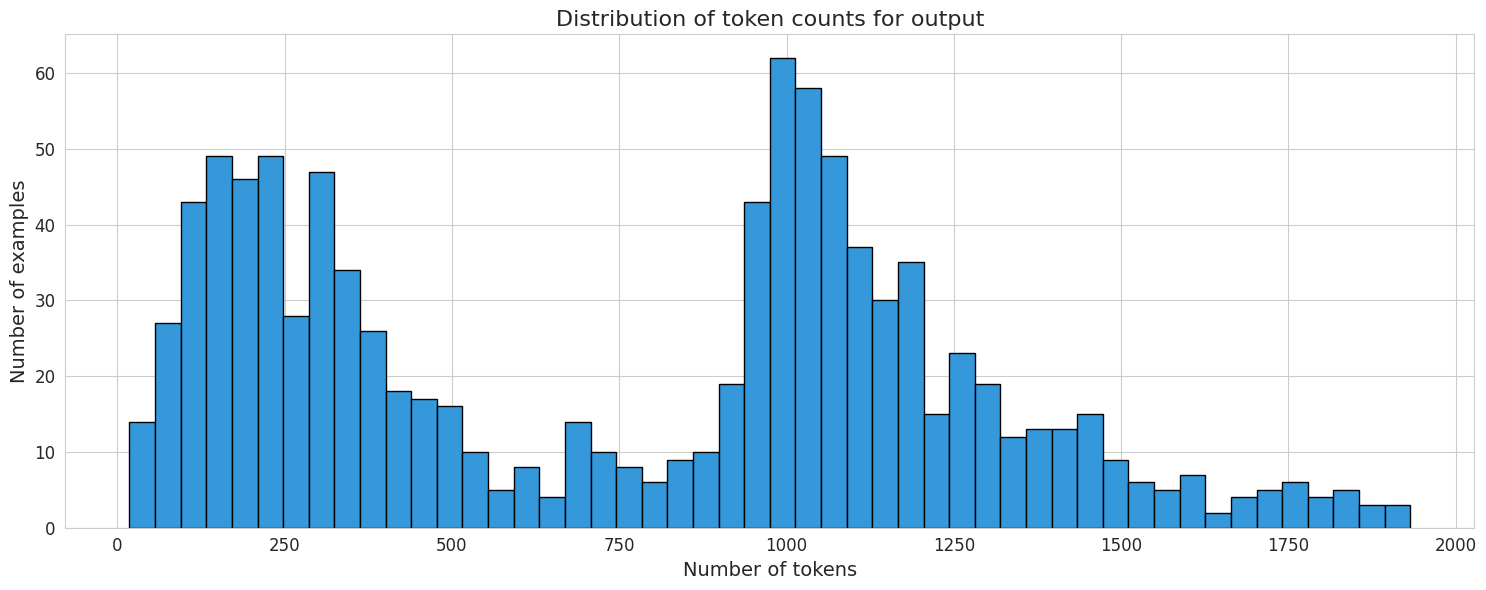

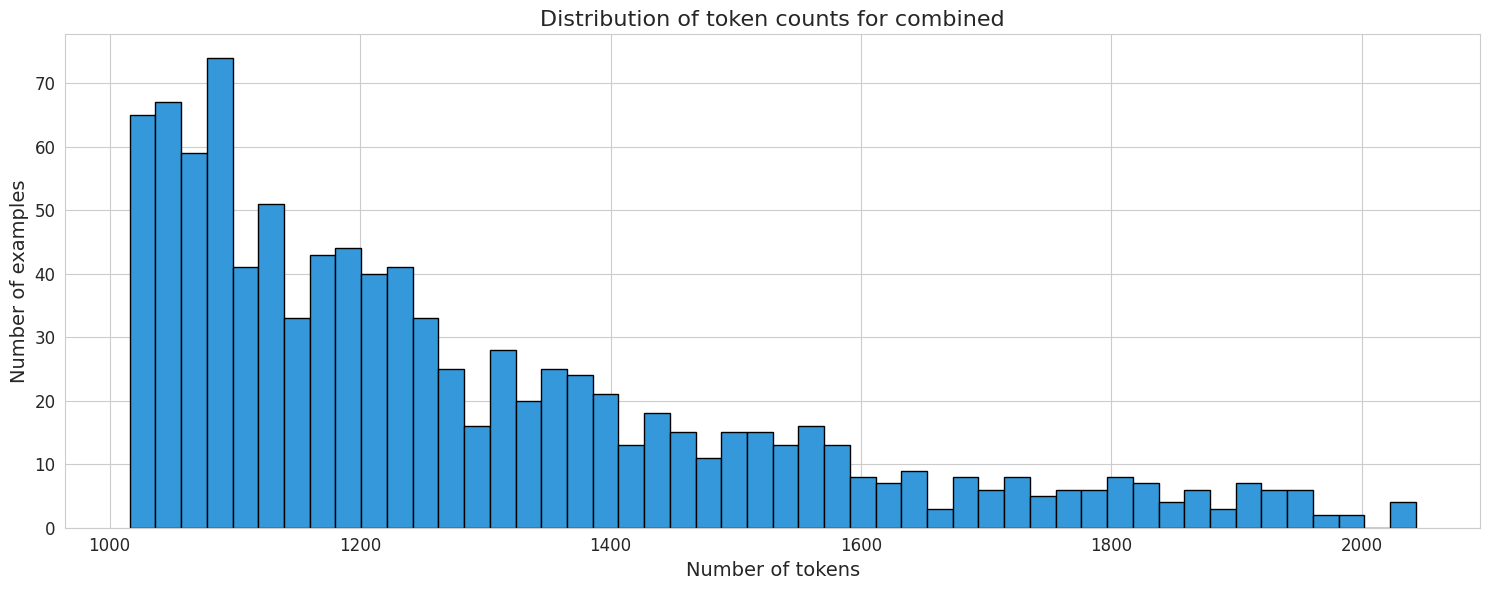

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

plot_distribution(instruction_token_counts, "Distribution of token counts for instruction")
plot_distribution(output_token_counts, "Distribution of token counts for output")
plot_distribution(combined_token_counts, "Distribution of token counts for combined")

In [ ]:
dataset["train"].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,BEGININPUT\nBEGINCONTEXT\ndate: 2023-07-15\nau...,The main changes made to the `autofocus.py` mo...
996,The setting is a gathering of friends discussi...,"Alice: ""Hey everyone, have you ever wondered h..."
997,I need to copy files from a computer folder to...,Sure! Here's a sample bash script that should ...
998,"In Cartesian space, three spheres centered at ...",The equation for the $xy$-plane is $z = 0.$\n\...


In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset["train"].to_pandas()

In [ ]:
dataset.push_to_hub("refined-platypus", token=hf_token)